# Bayesian optimisation for model selection

In [674]:
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions

from check_shape import check_shape
from tqdm import tqdm

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.decomposition import KernelPCA

from IPython.display import HTML, set_matplotlib_formats

from itertools import product

from tqdm import tqdm

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

/tmp/ipykernel_3096582/3384996101.py:25: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


<div class="definition">
    
**Definition (Hellinger distance)** The squared Hellinger distance between two distributions $P_1$ and $P_2$ with corresponding densities $p_1$ and $p_2$ is defined as
    
$$\begin{equation}
H^2(P_1, P_2) = \frac{1}{2} \int \left(\sqrt{p_1(x)} - \sqrt{p_2(x)} \right)^2 dx = 1 - \int \sqrt{p_1(x) p_2(x)}~dx.
\end{equation}$$
    
</div>
<br>


<div class="lemma">
    
**Lemma (Hellinger distance is a metric)** The Hellinger distance is a distance metric, meaning that for any distributions $P_1$, $P_2$ and $P_3$, it satisfies:
  
1. **Symmetry:** $H(P_1, P_2) = H(P_2, P_1)$.
2. **Reflexivity:** $H(P_1, P_2) = 0$ if and only if $P_1 = P_2$.
3. **Triangle inequality:** $H(P_1, P_2) + H(P_2, P_3) \geq H(P_1, P_3)$.

    
</div>
<br>


In [636]:
@tf.function
def gaussian_hellinger(m1, K1, m2, K2):
    
    check_shape(
        [m1, K1, m2, K2],
        [("N",), ("N", "N"), ("N",), ("N", "N")]
    )
    
    chol_sum_K = tf.linalg.cholesky((K1 + K2) / 2.)
    
    logdet_K1 = tf.linalg.logdet(K1)
    logdet_K2 = tf.linalg.logdet(K2)
    
    diff = m1 - m2
    
    i_sum_K_diff = tf.linalg.cholesky_solve(
        chol_sum_K,
        diff[:, None]
    )[:, 0]
    
    quad_term = tf.reduce_sum(diff * i_sum_K_diff)
    
    logdet_sum = 2. * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(chol_sum_K)))
    
    logdet_term = logdet_K1 / 4. + logdet_K2 / 4. - logdet_sum / 2.
    
    hellinger = 1 - tf.math.exp(logdet_term - quad_term / 8.)
    
    return hellinger

In [189]:
import tensorflow as tf
import tensorflow_probability as tfp

class ConstantMean(tf.keras.Model):

    def __init__(self,
                 dtype,
                 name='constant_mean'):
        
        super().__init__(name=name, dtype=dtype)
        
        self.constant = tf.Variable(tf.constant(0., dtype=dtype))
        
        
    def __call__(self, x):
        return self.constant * tf.ones(x.shape[0], dtype=self.dtype)
    
    
class EQCovariance(tf.keras.Model):

    def __init__(self, 
                 log_coeff,
                 log_scales,
                 dim,
                 dtype,
                 trainable=True,
                 name='eq_covariance',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
    
        # Convert parameters to tensors
        log_coeff = tf.convert_to_tensor(log_coeff, dtype=dtype)
        log_scales = tf.convert_to_tensor(log_scales, dtype=dtype)

        # Reshape parameter tensors
        log_coeff = tf.squeeze(log_coeff)
        log_scales = tf.reshape(log_scales, (-1,))
        
        # Set input dimensionality
        self.dim = dim
        
        # Set EQ parameters
        self.log_scales = tf.Variable(log_scales, trainable=trainable)
        self.log_coeff = tf.Variable(log_coeff, trainable=trainable)
        
        
    def __call__(self,
                 x1,
                 x2,
                 diag=False,
                 epsilon=None):
        
        # Convert to tensors
        x1 = tf.convert_to_tensor(x1, dtype=self.dtype)
        x2 = tf.convert_to_tensor(x2, dtype=self.dtype)

        # Get vector of lengthscales
        scales = self.scales
        
        # If calculating full covariance, add dimensions to broadcast
        if not diag:

            x1 = x1[:, None, :]
            x2 = x2[None, :, :]

            scales = self.scales[None, None, :] ** 2

        # Compute quadratic, exponentiate and multiply by coefficient
        quad = - 0.5 * (x1 - x2) ** 2 / scales
        quad = tf.reduce_sum(quad, axis=-1)
        eq_cov = self.coeff ** 2 * tf.exp(quad)
        
        # Add jitter for invertibility
        if epsilon is not None:
            eq_cov = eq_cov + epsilon * tf.eye(eq_cov.shape[0], 
                                               dtype=self.dtype)

        return eq_cov
        
    
    @property
    def scales(self):
        return tf.math.exp(self.log_scales)
    
    
    @property
    def coeff(self):
        return tf.math.exp(self.log_coeff)
    
    
    def sample_rff(self, num_features):

        # Dimension of data space
        x_dim = self.scales.shape[0]
        omega_shape = (num_features, x_dim)

        omega = tf.random.normal(shape=(num_features, x_dim), dtype=self.dtype)

        # Scale omegas by lengthscale
        omega = omega / self.scales[None, :]

        # Draw normally distributed RFF weights
        weights = tf.random.normal(mean=0.,
                                   stddev=1.,
                                   shape=(num_features,),
                                   dtype=self.dtype)

        phi = tf.random.uniform(minval=0.,
                                maxval=(2 * np.pi),
                                shape=(num_features, x_dim),
                                dtype=self.dtype)

        def rff(x):
        
            features = tf.cos(tf.einsum('fd, nd -> fn', omega, x) + phi)
            features = (2 / num_features) ** 0.5 * features * self.coeff

            return tf.einsum('f, fn -> n', weights, features)

        return rff
    
    
    
    
class LaplaceCovariance(tf.keras.Model):

    def __init__(self, 
                 log_coeff,
                 log_scales,
                 dim,
                 dtype,
                 trainable=True,
                 name='laplace_covariance',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
    
        # Convert parameters to tensors
        log_coeff = tf.convert_to_tensor(log_coeff, dtype=dtype)
        log_scales = tf.convert_to_tensor(log_scales, dtype=dtype)

        # Reshape parameter tensors
        log_coeff = tf.squeeze(log_coeff)
        log_scales = tf.reshape(log_scales, (-1,))
        
        # Set input dimensionality
        self.dim = dim
        
        # Set EQ parameters
        self.log_scales = tf.Variable(log_scales, trainable=trainable)
        self.log_coeff = tf.Variable(log_coeff, trainable=trainable)
        
        
    def __call__(self,
                 x1,
                 x2,
                 diag=False,
                 epsilon=None):
        
        # Convert to tensors
        x1 = tf.convert_to_tensor(x1, dtype=self.dtype)
        x2 = tf.convert_to_tensor(x2, dtype=self.dtype)

        # Get vector of lengthscales
        scales = self.scales
        
        # If calculating full covariance, add dimensions to broadcast
        if not diag:

            x1 = x1[:, None, :]
            x2 = x2[None, :, :]

            scales = self.scales[None, None, :]

        # Compute quadratic, exponentiate and multiply by coefficient
        abs_diff = - tf.math.abs(x1 - x2) / scales
        abs_diff = tf.reduce_sum(abs_diff, axis=-1)
        eq_cov = self.coeff ** 2 * tf.exp(abs_diff)

        return eq_cov
        
    @property
    def scales(self):
        return tf.math.exp(self.log_scales)
    
    @property
    def coeff(self):
        return tf.math.exp(self.log_coeff)
    
    
class CauchyCovariance(tf.keras.Model):

    def __init__(self, 
                 log_coeff,
                 log_scales,
                 dim,
                 dtype,
                 trainable=True,
                 name='laplace_covariance',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
    
        # Convert parameters to tensors
        log_coeff = tf.convert_to_tensor(log_coeff, dtype=dtype)
        log_scales = tf.convert_to_tensor(log_scales, dtype=dtype)

        # Reshape parameter tensors
        log_coeff = tf.squeeze(log_coeff)
        log_scales = tf.reshape(log_scales, (-1,))
        
        # Set input dimensionality
        self.dim = dim
        
        # Set EQ parameters
        self.log_scales = tf.Variable(log_scales, trainable=trainable)
        self.log_coeff = tf.Variable(log_coeff, trainable=trainable)
        
        
    def __call__(self,
                 x1,
                 x2,
                 diag=False,
                 epsilon=None):
        
        # Convert to tensors
        x1 = tf.convert_to_tensor(x1, dtype=self.dtype)
        x2 = tf.convert_to_tensor(x2, dtype=self.dtype)

        # Get vector of lengthscales
        scales = self.scales
        
        # If calculating full covariance, add dimensions to broadcast
        if not diag:

            x1 = x1[:, None, :]
            x2 = x2[None, :, :]

            scales = self.scales[None, None, :]

        # Compute quadratic, exponentiate and multiply by coefficient
        quad = ((x1 - x2) / scales) ** 2.
        quad = tf.reduce_sum(quad, axis=-1)
        eq_cov = self.coeff ** 2 / (1. + quad)

        return eq_cov
        
    @property
    def scales(self):
        return tf.math.exp(self.log_scales)
    
    @property
    def coeff(self):
        return tf.math.exp(self.log_coeff)

In [212]:
log_coeff_1 = 0.0
log_scales_1 = 0.0

log_coeff_2 = 0.
log_scales_2 = 0.

dim = 1
dtype = tf.float64

mean1 = ConstantMean(dtype=dtype)
cov1 = EQCovariance(
    log_coeff=log_coeff_1,
    log_scales=log_scales_1,
    dim=dim,
    dtype=dtype,
)

mean2 = ConstantMean(dtype=dtype)
cov2 = CauchyCovariance(
    log_coeff=log_coeff_2,
    log_scales=log_scales_2,
    dim=dim,
    dtype=dtype,
)

In [253]:
N = 10

x_train = 0.5 * (2. * tf.random.uniform(shape=(N, 1), dtype=dtype) - 1.)

m1 = mean1(x_train)
m2 = mean2(x_train)

K1 = cov1(x_train, x_train) + 1e-2 * tf.eye(N, dtype=dtype)
K2 = cov2(x_train, x_train) + 1e-2 * tf.eye(N, dtype=dtype)

print(m1.shape, m2.shape)
print(K1.shape, K2.shape)

gaussian_hellinger(m1, K1, m2, K2)

(10,) (10,)
(10, 10) (10, 10)


<tf.Tensor: shape=(), dtype=float64, numpy=0.6563583548845552>

In [256]:
num_coeffs = 10
num_scales = 200

log_coeffs = tf.cast(tf.linspace(-np.log(10), np.log(10), num_coeffs), dtype=dtype)
log_scales = tf.cast(tf.linspace(-np.log(10), np.log(10), num_scales), dtype=dtype)

parameters = tf.stack(tf.meshgrid(log_coeffs, log_scales), axis=-1)

noise = 1e-3
log_coeff_1 = 0.
log_scales_1 = 0.

mean1 = ConstantMean(dtype=dtype)
cov1 = EQCovariance(
    log_coeff=log_coeff_1,
    log_scales=log_scales_1,
    dim=dim,
    dtype=dtype,
)

mean2 = ConstantMean(dtype=dtype)

distances = np.zeros(shape=(num_coeffs, num_scales))

for i in range(num_coeffs):
    for j in range(num_scales):
        
        log_coeff_2, log_scale_2 = parameters[j, i]
    
        cov2 = CauchyCovariance(
            log_coeff=log_coeff_2,
            log_scales=log_scale_2,
            dim=dim,
            dtype=dtype,
        )

        m1 = mean1(x_train)
        m2 = mean2(x_train)

        K1 = cov1(x_train, x_train) + noise**2 * tf.eye(N, dtype=dtype)
        K2 = cov2(x_train, x_train) + noise**2 * tf.eye(N, dtype=dtype)

        distances[i, j] = float(gaussian_hellinger(m1=m1, K1=K1, m2=m2, K2=K2))

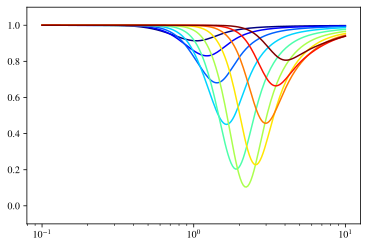

In [257]:
colors = log_coeffs.numpy()
colors = colors - colors.min()
colors = colors / colors.max()
colors = plt.cm.jet(colors)

for i in range(num_coeffs):
    plt.plot(tf.math.exp(log_scales), distances[i], color=colors[i])
    
plt.xticks([])
plt.ylim([-0.1, 1.1])
plt.xscale("log")
plt.show()

In [855]:
def kl_divergence(m1, K1, m2, K2):
    
    p1 = tfd.MultivariateNormalFullCovariance(loc=m1, covariance_matrix=K1)
    p2 = tfd.MultivariateNormalFullCovariance(loc=m2, covariance_matrix=K2)
    
    return p1.kl_divergence(p2)

@tf.function
def symmetrised_kl_divergence(m1, K1, m2, K2):
    return kl_divergence(m1, K1, m2, K2) + kl_divergence(m2, K2, m1, K1)

kl_divergence(m1, K1, m2, K2), kl_divergence(m2, K2, m1, K1), symmetrised_kl_divergence(m1, K1, m2, K2)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.0>)

In [269]:
num_coeffs = 10
num_scales = 100

log_coeffs = tf.cast(tf.linspace(-1., 1., num_coeffs), dtype=dtype)
log_scales = tf.cast(tf.linspace(-1., 1., num_scales), dtype=dtype)

parameters = tf.stack(tf.meshgrid(log_coeffs, log_scales), axis=-1)

log_coeff_1 = 0.
log_scales_1 = 0.

mean1 = ConstantMean(dtype=dtype)
cov1 = EQCovariance(
    log_coeff=log_coeff_1,
    log_scales=log_scales_1,
    dim=dim,
    dtype=dtype,
)

mean2 = ConstantMean(dtype=dtype)

distances = np.zeros(shape=(num_coeffs, num_scales))

for i in range(num_coeffs):
    for j in range(num_scales):
        
        log_coeff_2, log_scale_2 = parameters[j, i]
    
        cov2 = EQCovariance(
            log_coeff=log_coeff_2,
            log_scales=log_scale_2,
            dim=dim,
            dtype=dtype,
        )

        m1 = mean1(x_train)
        m2 = mean2(x_train)

        K1 = cov1(x_train, x_train) + 1e-2 * tf.eye(N, dtype=dtype)
        K2 = cov2(x_train, x_train) + 1e-2 * tf.eye(N, dtype=dtype)

        distances[i, j] = float(symmetrised_kl_divergence(m1=m1, K1=K1, m2=m2, K2=K2))

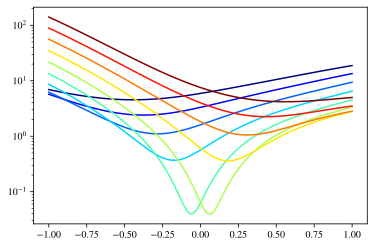

In [270]:
colors = log_coeffs.numpy()
colors = colors - colors.min()
colors = colors / colors.max()
colors = plt.cm.jet(colors)

for i in range(num_coeffs):
    plt.plot(log_scales, distances[i], color=colors[i])
    
plt.yscale("log")
plt.show()

In [305]:
def compute_distances(
        num_coeffs,
        num_scales,
        noise,
        covariance1,
        covariance2,
        x_train,
        distance,
        log_scales,
        log_coeffs,
    ):

    parameters = tf.stack(tf.meshgrid(log_coeffs, log_scales), axis=-1)

    log_coeff_1 = 0.
    log_scales_1 = 0.

    mean1 = ConstantMean(dtype=dtype)
    cov1 = covariance1(
        log_coeff=log_coeff_1,
        log_scales=log_scales_1,
        dim=dim,
        dtype=dtype,
    )

    mean2 = ConstantMean(dtype=dtype)

    distances = np.zeros(shape=(num_coeffs, num_scales))

    for i in range(num_coeffs):
        for j in range(num_scales):

            log_coeff_2, log_scale_2 = parameters[j, i]

            cov2 = covariance2(
                log_coeff=log_coeff_2,
                log_scales=log_scale_2,
                dim=dim,
                dtype=dtype,
            )

            m1 = mean1(x_train)
            m2 = mean2(x_train)

            K1 = cov1(x_train, x_train) + noise**2. * tf.eye(N, dtype=dtype)
            K2 = cov2(x_train, x_train) + noise**2. * tf.eye(N, dtype=dtype)

            distances[i, j] = float(distance(m1=m1, K1=K1, m2=m2, K2=K2))
            
    return distances

In [493]:
N = 100

min_log_coeff=-np.log(10)
max_log_coeff=np.log(10)
min_log_scale=-np.log(100)
max_log_scale=np.log(100)

num_coeffs = 5
num_scales = 41

noise = 1.0

kernels = [
    (0, EQCovariance, "EQ"),
    (1, CauchyCovariance, "Cauchy"),
    (2, LaplaceCovariance, "Laplace")
]

x_train = 3.0 * (2. * tf.random.uniform(shape=(N, 1), dtype=dtype) - 1.)

log_coeffs = tf.cast(
    tf.linspace(
        min_log_coeff,
        max_log_coeff,
        num_coeffs
    ),
    dtype=dtype
)

log_scales = tf.cast(
    tf.linspace(
        min_log_scale,
        max_log_scale,
        num_scales
    ),
    dtype=dtype
)

distances = np.zeros(shape=(len(kernels), len(kernels), num_coeffs, num_scales))


for (i, c1, _), (j, c2, _) in product(kernels, kernels):

    distances[i, j] = compute_distances(
        num_coeffs=num_coeffs,
        num_scales=num_scales,
        noise=noise,
        covariance1=c1,
        covariance2=c2,
        x_train=x_train,
        distance=symmetrised_kl_divergence,
        log_scales=log_scales,
        log_coeffs=log_coeffs,
    ) / N

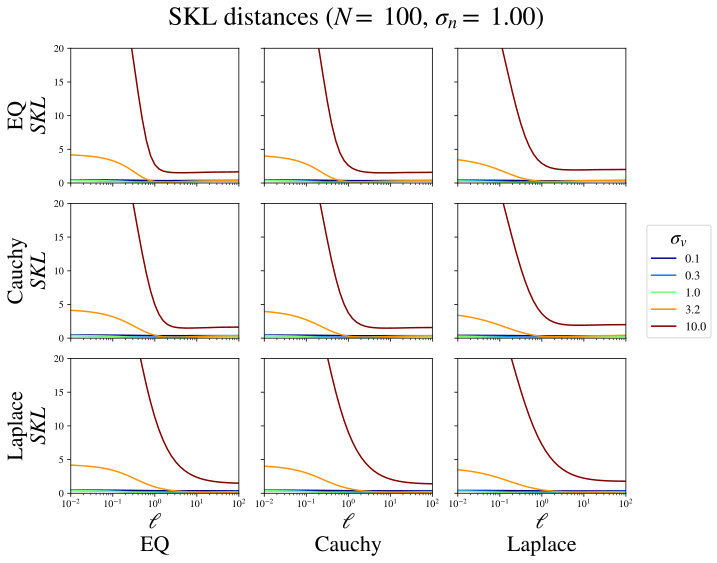

In [494]:
colors = log_coeffs.numpy()
colors = colors - colors.min()
colors = colors / colors.max()
colors = plt.cm.jet(colors)

figure = plt.figure(figsize=(10, 8))
figure.subplots(3, 3, sharex=True, sharey=True)

for (i, _, c1), (j, _, c2) in product(kernels, kernels):
    
    plt.subplot(3, 3, i+3*j+1)

    for k in range(num_coeffs):

        plt.plot(
            tf.math.exp(log_scales),
            distances[i, j, k],
            color=colors[k],
            label=f"{tf.math.exp(log_coeffs[k]):.1f}"
        )

    plt.xlim([1e-2, 1e2])
    plt.ylim([0.0, 20.0])
    plt.xscale("log")
        
    if i == 0:
        plt.ylabel(f"{c2}\n$SKL$", fontsize=22)
        
    if j == 2:
        plt.xlabel(f"$\\ell$\n{c1}", fontsize=22)
        
        
handles, labels = plt.gca().get_legend_handles_labels()
figure.legend(handles, labels, title=f"$\\sigma_v$", ncol=1, fontsize=12, loc="center right", title_fontsize=20)

# plt.subplot(3, 3, 3)
# plt.text(0.4, 0.4, f"$N = $ {N}, $\\sigma_n = $ {noise:.1f}", ha="center", va="center", fontsize=16)

plt.suptitle(f"SKL distances ($N = $ {N}, $\\sigma_n = $ {noise:.2f})", fontsize=26)
    
plt.tight_layout()
plt.subplots_adjust(right=0.875)
plt.savefig(f"SKL_N_{N}_noise_{noise}.pdf")
plt.show()

In [ ]:
# Is Hellinger distance from ground truth a good predictor for the marginal likelihood?

# How does the Hellinger distance compare to the symmetrised KL in terms of marginal likelihood?

In [871]:
class Dummy(tf.keras.Model):
    
    def __init__(
            self,
            log_scale,
            log_coeff,
            log_noise,
            name="dummy",
            **kwargs
        ):
        
        super().__init__(name=name, **kwargs)
        
        self.log_scale = tf.Variable(tf.convert_to_tensor(log_scale, dtype=dtype))
        self.log_coeff = tf.Variable(tf.convert_to_tensor(log_coeff, dtype=dtype))
        self.log_noise = tf.Variable(tf.convert_to_tensor(log_noise, dtype=dtype))

In [953]:
np.random.seed(0)

N = 50
x_train = 3.0 * (2. * tf.random.uniform(shape=(N, 1), dtype=dtype) - 1.)

true_mean = ConstantMean(dtype=dtype)
true_mean = true_mean(x_train)
true_covariance = CauchyCovariance(
    log_coeff=0.,
    log_scales=0.,
    dim=1,
    dtype=dtype
)
true_covariance = true_covariance(x_train, x_train) + 1e-2 * tf.eye(x_train.shape[0], dtype=dtype)

true_distribution = tfd.MultivariateNormalFullCovariance(loc=true_mean, covariance_matrix=true_covariance)

In [955]:
np.random.seed(0)

num_kernels = 50
kernels = []

for i in range(num_kernels):
    
    kernel_class = np.random.choice([EQCovariance, CauchyCovariance, LaplaceCovariance])
    
    log_scale = 2. * (2. * np.random.uniform() - 1.)
    log_variance = 2. * (2. * np.random.uniform() - 1.)
    log_noise = 2. * (2. * np.random.uniform() - 1.)
    
    kernels.append([kernel_class, log_scale, log_variance, log_noise])

hellinger_distances = np.zeros(shape=(num_kernels, num_kernels))
marginal_likelihoods = np.zeros(shape=(num_kernels,))

for i, (kernel_class_1, log_scale_1, log_coeff_1, log_noise_1) in enumerate(kernels):

    mean1 = ConstantMean(dtype=dtype)
    cov1 = kernel_class_1(
        log_coeff=log_coeff_1,
        log_scales=log_scale_1,
        dim=dim,
        dtype=dtype,
    )
    
    m1 = mean1(x_train)
    K1 = cov1(x_train, x_train) + noise**2. * tf.eye(N, dtype=dtype)
        
    for j, (kernel_class_2, log_scale_2, log_coeff_2, log_noise_2) in enumerate(kernels):

        mean2 = ConstantMean(dtype=dtype)
        cov2 = kernel_class_1(
            log_coeff=log_coeff_2,
            log_scales=log_scale_2,
            dim=dim,
            dtype=dtype,
        )

        m2 = mean2(x_train)
        K2 = cov2(x_train, x_train) + noise**2. * tf.eye(N, dtype=dtype)

        hellinger_distances[i, j] = float(gaussian_hellinger(m1=m1, K1=K1, m2=m2, K2=K2))
        
    
    distribution = tfd.MultivariateNormalFullCovariance(loc=m1, covariance_matrix=K1)
    marginal_likelihoods[i] = float(true_distribution.cross_entropy(distribution))

In [956]:
dummy = Dummy(
    log_scale=0.,
    log_coeff=0.,
    log_noise=1.,
)

parameters = [
    surrogate_log_scale,
    surrogate_log_coeff,
    surrogate_log_noise,
]

num_steps = 20000
optimiser = tf.keras.optimizers.Adam(lr=5e-5)


@tf.function
def train_step(model, optimiser):
    
    with tf.GradientTape() as tape:
        
        tape.watch(dummy.trainable_variables)
        
        surrogate_scale = tf.math.exp(dummy.log_scale)
        surrogate_coeff = tf.math.exp(dummy.log_coeff)
        surrogate_noise = tf.math.exp(dummy.log_noise)
        
        surrogate_mean = tf.zeros(shape=(num_kernels,), dtype=dtype)
        surrogate_covariance = surrogate_coeff**2. * tf.math.exp(-0.5 * (hellinger_distances / surrogate_scale) ** 2.)
        surrogate_covariance = surrogate_covariance + surrogate_noise**2. * tf.eye(num_kernels, dtype=dtype)
        
        predictive = tfd.MultivariateNormalFullCovariance(loc=surrogate_mean, covariance_matrix=surrogate_covariance)
        loss = - predictive.log_prob(marginal_likelihoods - marginal_likelihoods.mean())
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss
    

for i in range(num_steps):
    
    loss = train_step(dummy, optimiser)
    
    if i % 1000 == 0:
        print(f"Loss {loss:.3f}, Lengthscale {tf.math.exp(dummy.log_scale):.3f}, Coeff {tf.math.exp(dummy.log_coeff):.3f}, Noise {tf.math.exp(dummy.log_noise):.3f}")

/home/stratis.markou/repos/random-walks/venv-random-walks/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Loss 200.193, Lengthscale 1.000, Coeff 1.000, Noise 2.718
Loss 191.326, Lengthscale 0.952, Coeff 1.050, Noise 2.852
Loss 184.069, Lengthscale 0.909, Coeff 1.102, Noise 2.981
Loss 178.016, Lengthscale 0.869, Coeff 1.155, Noise 3.108
Loss 172.916, Lengthscale 0.831, Coeff 1.210, Noise 3.234
Loss 168.603, Lengthscale 0.795, Coeff 1.268, Noise 3.359
Loss 164.958, Lengthscale 0.762, Coeff 1.328, Noise 3.483
Loss 161.886, Lengthscale 0.730, Coeff 1.391, Noise 3.602
Loss 159.300, Lengthscale 0.700, Coeff 1.457, Noise 3.712
Loss 157.109, Lengthscale 0.671, Coeff 1.527, Noise 3.802
Loss 155.193, Lengthscale 0.644, Coeff 1.601, Noise 3.850
Loss 153.349, Lengthscale 0.618, Coeff 1.681, Noise 3.811
Loss 151.292, Lengthscale 0.593, Coeff 1.769, Noise 3.650
Loss 148.934, Lengthscale 0.569, Coeff 1.865, Noise 3.438
Loss 146.385, Lengthscale 0.549, Coeff 1.966, Noise 3.233
Loss 143.729, Lengthscale 0.532, Coeff 2.073, Noise 3.045
Loss 141.007, Lengthscale 0.519, Coeff 2.184, Noise 2.874
Loss 138.255, 

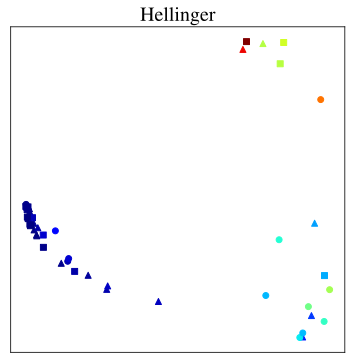

In [957]:
surrogate_scale = tf.math.exp(dummy.log_scale)
surrogate_coeff = tf.math.exp(dummy.log_coeff)
surrogate_noise = tf.math.exp(dummy.log_noise)
        
surrogate_covariance = surrogate_coeff**2. * tf.math.exp(-0.5 * (hellinger_distances / surrogate_scale) ** 2.)
precomputed = surrogate_covariance + surrogate_noise**2. * tf.eye(num_kernels, dtype=dtype)

kernel = KernelPCA(
    n_components=2,
    kernel="precomputed",
)
x = kernel.fit_transform(precomputed)

sml = marginal_likelihoods
sml = sml - sml.min()
sml = sml / sml.max()
color = plt.cm.jet(sml)

markers = np.array(["^", "s", "o"])
kernel_classes = [EQCovariance, CauchyCovariance, LaplaceCovariance]

idx = [
    [
        k is kernel_class for k, _, _, _ in kernels
    ]
    for kernel_class in kernel_classes
]

plt.figure(figsize=(6, 6))

for i, _idx in enumerate(idx):
    plt.scatter(x[_idx, 0], x[_idx, 1], color=color[_idx], marker=markers[i])
    
plt.title("Hellinger", fontsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig("hellinger_visualisation_cauchy.png")
plt.show()

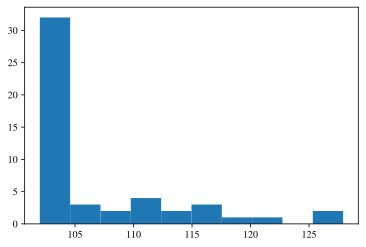

In [958]:
plt.hist(marginal_likelihoods)
plt.show()

/tmp/ipykernel_3096582/1788922642.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("hellinger_scatterplot_cauchy.png", fontsize=18)


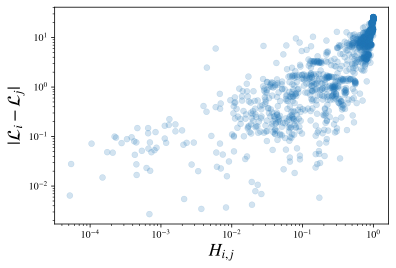

In [959]:
ml_diff = np.abs(marginal_likelihoods[:, None] - marginal_likelihoods[None, :])

d = []
m = []

for i, _ in enumerate(kernels):
    for j, _ in enumerate(kernels):
        if i <= j:
            d.append(hellinger_distances[i, j])
            m.append(ml_diff[i, j])

plt.scatter(d, m, alpha=0.2, linewidth=0.5)
plt.xlabel("$H_{i, j}$", fontsize=18)
# plt.xlabel("$SKL_{i, j}$", fontsize=18)
plt.ylabel("$|\mathcal{L}_i - \mathcal{L}_j|$", fontsize=18)
plt.xscale("log")
plt.yscale("log")
# plt.ylim([-0.5, 5])
plt.savefig("hellinger_scatterplot_cauchy.png", fontsize=18)
plt.show()

In [ ]:
skl_distances = np.zeros(shape=(num_kernels, num_kernels))
marginal_likelihoods = np.zeros(shape=(num_kernels,))

for i, (kernel_class_1, log_scale_1, log_coeff_1, log_noise_1) in enumerate(kernels):

    mean1 = ConstantMean(dtype=dtype)
    cov1 = kernel_class_1(
        log_coeff=log_coeff_1,
        log_scales=log_scale_1,
        dim=dim,
        dtype=dtype,
    )
    
    m1 = mean1(x_train)
    K1 = cov1(x_train, x_train) + noise**2. * tf.eye(N, dtype=dtype)
        
    for j, (kernel_class_2, log_scale_2, log_coeff_2, log_noise_2) in enumerate(kernels):

        mean2 = ConstantMean(dtype=dtype)
        cov2 = kernel_class_1(
            log_coeff=log_coeff_2,
            log_scales=log_scale_2,
            dim=dim,
            dtype=dtype,
        )

        m2 = mean2(x_train)
        K2 = cov2(x_train, x_train) + noise**2. * tf.eye(N, dtype=dtype)

        skl_distances[i, j] = float(symmetrised_kl_divergence(m1=m1, K1=K1, m2=m2, K2=K2))
        
    
    distribution = tfd.MultivariateNormalFullCovariance(loc=m1, covariance_matrix=K1)
    marginal_likelihoods[i] = float(true_distribution.cross_entropy(distribution))

In [931]:
dummy = Dummy(
    log_scale=0.,
    log_coeff=0.,
    log_noise=1.,
)

parameters = [
    surrogate_log_scale,
    surrogate_log_coeff,
    surrogate_log_noise,
]

num_steps = 40000
optimiser = tf.keras.optimizers.Adam(lr=5e-5)


@tf.function
def train_step(model, optimiser):
    
    with tf.GradientTape() as tape:
        
        tape.watch(dummy.trainable_variables)
        
        surrogate_scale = tf.math.exp(dummy.log_scale)
        surrogate_coeff = tf.math.exp(dummy.log_coeff)
        surrogate_noise = tf.math.exp(dummy.log_noise)
        
        surrogate_mean = tf.zeros(shape=(num_kernels,), dtype=dtype)
        surrogate_covariance = surrogate_coeff**2. * tf.math.exp(-0.5 * (skl_distances / surrogate_scale) ** 2.)
        surrogate_covariance = surrogate_covariance + surrogate_noise**2. * tf.eye(num_kernels, dtype=dtype)
        
        predictive = tfd.MultivariateNormalFullCovariance(loc=surrogate_mean, covariance_matrix=surrogate_covariance)
        loss = - predictive.log_prob(marginal_likelihoods - marginal_likelihoods.mean())
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss
    

for i in range(num_steps+1):
    
    loss = train_step(dummy, optimiser)
    
    if i % 1000 == 0:
        print(f"Loss {loss:.3f}, Lengthscale {tf.math.exp(dummy.log_scale):.3f}, Coeff {tf.math.exp(dummy.log_coeff):.3f}, Noise {tf.math.exp(dummy.log_noise):.3f}")

/home/stratis.markou/repos/random-walks/venv-random-walks/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Loss 334.318, Lengthscale 1.000, Coeff 1.000, Noise 2.718
Loss 325.675, Lengthscale 1.050, Coeff 1.050, Noise 2.851
Loss 318.673, Lengthscale 1.102, Coeff 1.101, Noise 2.979
Loss 312.891, Lengthscale 1.155, Coeff 1.154, Noise 3.103
Loss 308.063, Lengthscale 1.211, Coeff 1.209, Noise 3.222
Loss 304.005, Lengthscale 1.269, Coeff 1.266, Noise 3.336
Loss 300.565, Lengthscale 1.331, Coeff 1.327, Noise 3.438
Loss 297.583, Lengthscale 1.396, Coeff 1.391, Noise 3.517
Loss 294.820, Lengthscale 1.466, Coeff 1.460, Noise 3.547
Loss 291.821, Lengthscale 1.542, Coeff 1.535, Noise 3.478
Loss 287.990, Lengthscale 1.626, Coeff 1.619, Noise 3.300
Loss 283.167, Lengthscale 1.716, Coeff 1.711, Noise 3.093
Loss 277.500, Lengthscale 1.810, Coeff 1.809, Noise 2.898
Loss 271.925, Lengthscale 1.895, Coeff 1.908, Noise 2.742
Loss 270.428, Lengthscale 1.901, Coeff 1.972, Noise 2.825
Loss 269.156, Lengthscale 1.891, Coeff 2.043, Noise 2.919
Loss 268.171, Lengthscale 1.872, Coeff 2.118, Noise 3.016
Loss 267.501, 

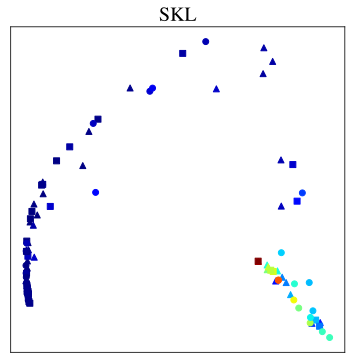

In [951]:
surrogate_scale = tf.math.exp(dummy.log_scale)
surrogate_coeff = tf.math.exp(dummy.log_coeff)
surrogate_noise = tf.math.exp(dummy.log_noise)
        
surrogate_covariance = surrogate_coeff**2. * tf.math.exp(-0.5 * (skl_distances / surrogate_scale) ** 2.)
precomputed = surrogate_covariance + surrogate_noise**2. * tf.eye(num_kernels, dtype=dtype)

kernel = KernelPCA(
    n_components=2,
    kernel="precomputed",
)
x = kernel.fit_transform(precomputed)

sml = marginal_likelihoods
sml = sml - sml.min()
sml = sml / sml.max()
color = plt.cm.jet(sml)

markers = np.array(["^", "s", "o"])
kernel_classes = [EQCovariance, CauchyCovariance, LaplaceCovariance]

idx = [
    [
        k is kernel_class for k, _, _, _ in kernels
    ]
    for kernel_class in kernel_classes
]

plt.figure(figsize=(6, 6))

for i, _idx in enumerate(idx):
    plt.scatter(x[_idx, 0], x[_idx, 1], color=color[_idx], marker=markers[i])
    
plt.title("SKL", fontsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig("skl_visualisation.png")
plt.show()

/tmp/ipykernel_3096582/2728438228.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("skl_scatterplot.png", fontsize=18)


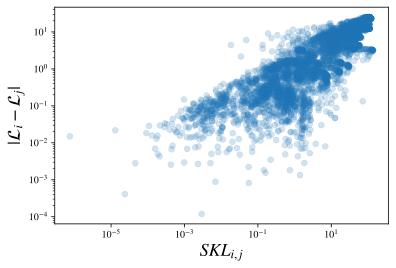

In [952]:
ml_diff = np.abs(marginal_likelihoods[:, None] - marginal_likelihoods[None, :])

d = []
m = []

for i, _ in enumerate(kernels):
    for j, _ in enumerate(kernels):
        if i <= j:
            d.append(skl_distances[i, j])
            m.append(ml_diff[i, j])

plt.scatter(d, m, alpha=0.2, linewidth=0.5)
plt.xlabel("$SKL_{i, j}$", fontsize=18)
# plt.xlabel("$SKL_{i, j}$", fontsize=18)
plt.ylabel("$|\mathcal{L}_i - \mathcal{L}_j|$", fontsize=18)
plt.xscale("log")
plt.yscale("log")
# plt.ylim([-0.5, 5])
plt.savefig("skl_scatterplot.png", fontsize=18)

plt.show()